In [37]:

import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [38]:
# include only those gestures
CONDITIONS = ['dislike', 'like', 'peace', 'rock', 'stop']

# Path to HaGRID dataset -> has to be adjsuted!
PATH_DATASET = '../data/gesture_dataset_sample'
PATH_DATASET_LUCA = './data-escher'
PATH_JSON_LUCA = './annot-escher.json'

# image size
SIZE = 64

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

In [39]:
annotations = dict()
luca_annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH_DATASET}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

    with open(f'{PATH_JSON_LUCA}') as g:
        luca_annotations[condition] = json.load(g)


### Use and adjust scipt from lecture:

In [40]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, (SIZE, SIZE))
    return img_resized

In [41]:
# load images and annotations from dataset

images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH_DATASET}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH_DATASET}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(filename)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                if label != 'no_gesture':
                    label_names.append(label)
                    print(label)
            
            if label != 'no_gesture':
                label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

dislike


  0%|          | 0/250 [00:00<?, ?it/s]

like


  0%|          | 0/250 [00:00<?, ?it/s]

peace


  0%|          | 0/250 [00:00<?, ?it/s]

rock


  0%|          | 0/250 [00:00<?, ?it/s]

stop


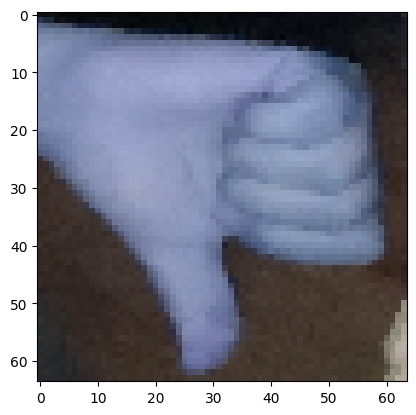

In [42]:
plt.imshow(random.sample(images, 1)[0])

## Do the same with my data

In [43]:
# load images and annotations from dataset

luca_images = [] # stores actual image data
luca_labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH_DATASET_LUCA}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH_DATASET_LUCA}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = luca_annotations[condition][UID]
        except Exception as e:
            print(f'Something went wrong with the annotations: {filename}')
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
                print(label)
            
            label_index = label_names.index(label)
            
            luca_images.append(preprocessed)
            luca_labels.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

dislike


  0%|          | 0/3 [00:00<?, ?it/s]

like


  0%|          | 0/3 [00:00<?, ?it/s]

peace


  0%|          | 0/3 [00:00<?, ?it/s]

rock


  0%|          | 0/3 [00:00<?, ?it/s]

stop


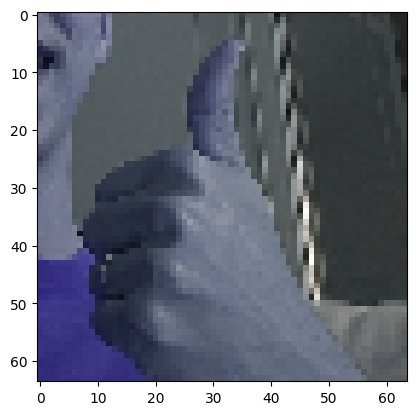

In [44]:
plt.imshow(random.sample(luca_images, 1)[0])

In [45]:
# preprocess data

X_train = images
X_test = luca_images
y_train = labels
y_test = luca_labels

X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, SIZE, SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, SIZE, SIZE, COLOR_CHANNELS)

In [46]:
# create model

# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64
num_classes = len(label_names)



# define model structure
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE, SIZE, COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

/Users/luca/Projekte/Master/ITT/W6/assignment-5-cnn-LucaEscher/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## train model

In [47]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.1864 - loss: 1.6303 - val_accuracy: 0.2000 - val_loss: 1.6062 - learning_rate: 0.0010
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2405 - loss: 1.6153 - val_accuracy: 0.2000 - val_loss: 1.6711 - learning_rate: 0.0010
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.3005 - loss: 1.5678 - val_accuracy: 0.3333 - val_loss: 1.5841 - learning_rate: 0.0010
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3913 - loss: 1.3827 - val_accuracy: 0.1333 - val_loss: 1.5560 - learning_rate: 0.0010
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4754 - loss: 1.3070 - val_accuracy: 0.4000 - val_loss: 1.5096 - learning_rate: 0.0010
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5441 - loss: 1.1327 - val_accuracy: 0.6000 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6201 - loss: 0.

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_3               │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,233 (1.13 MB)

 Trainable params: 99,077 (387.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,156 (774.05 KB)

In [49]:
model.save('my_model.keras')

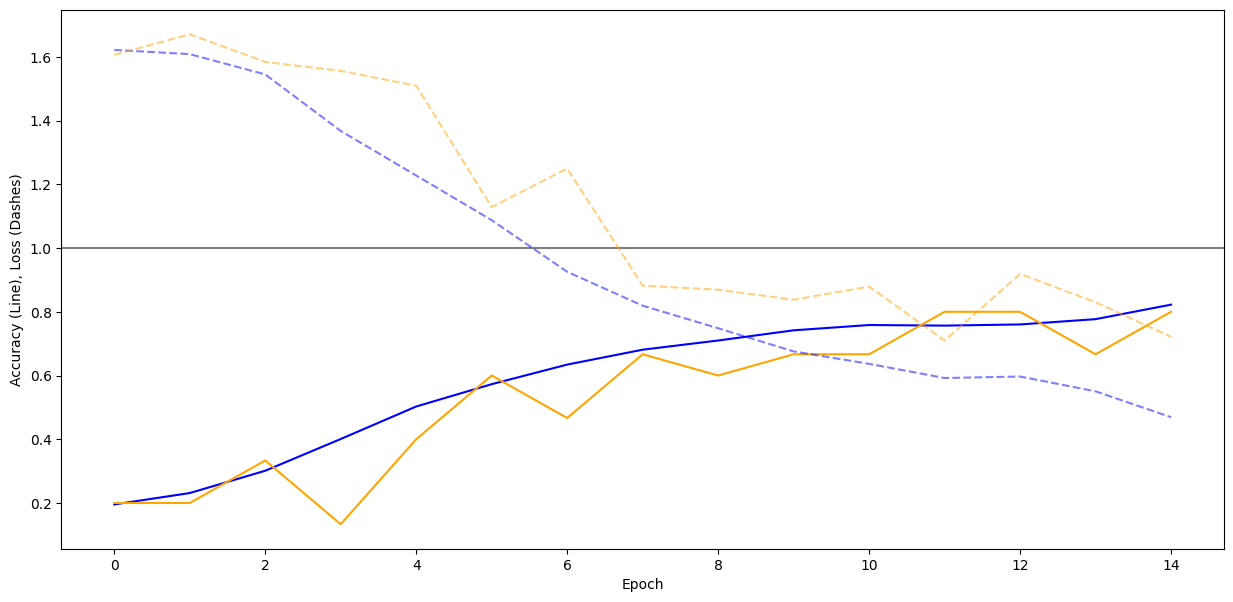

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
before [[4.24364299e-01 1.53202891e-01 1.13360517e-01 1.50850117e-01
  1.58222184e-01]
 [8.94751847e-01 2.00638343e-02 2.25197468e-02 2.79575158e-02
  3.47070917e-02]
 [9.95029807e-01 3.80159181e-04 6.32893003e-04 5.53778897e-04
  3.40335188e-03]
 [9.22973454e-03 8.32961202e-01 1.34546772e-01 1.39846525e-03
  2.18638182e-02]
 [8.16335529e-02 4.84724522e-01 2.44213238e-01 3.93690579e-02
  1.50059655e-01]
 [9.39739048e-02 2.14537516e-01 3.49882632e-01 1.81328237e-01
  1.60277680e-01]
 [2.25431100e-02 3.96342039e-01 5.02653778e-01 4.58483249e-02
  3.26127186e-02]
 [1.44359851e-02 1.10620065e-02 9.42738354e-01 2.80863810e-02
  3.67737585e-03]
 [4.35370930e-06 4.59212933e-05 9.99926567e-01 2.23834322e-05
  7.20349817e-07]
 [1.46010548e-01 1.48030147e-01 2.07764685e-01 3.26052368e-01
  1.72142208e-01]
 [2.37483550e-02 2.71041342e-03 8.12531114e-01 1.58580959e-01
  2.42905691e-03]
 [1.79032050e-03 1.87736575e-03 9.40618038e-01 5.53248040e-02
  3.89386463e

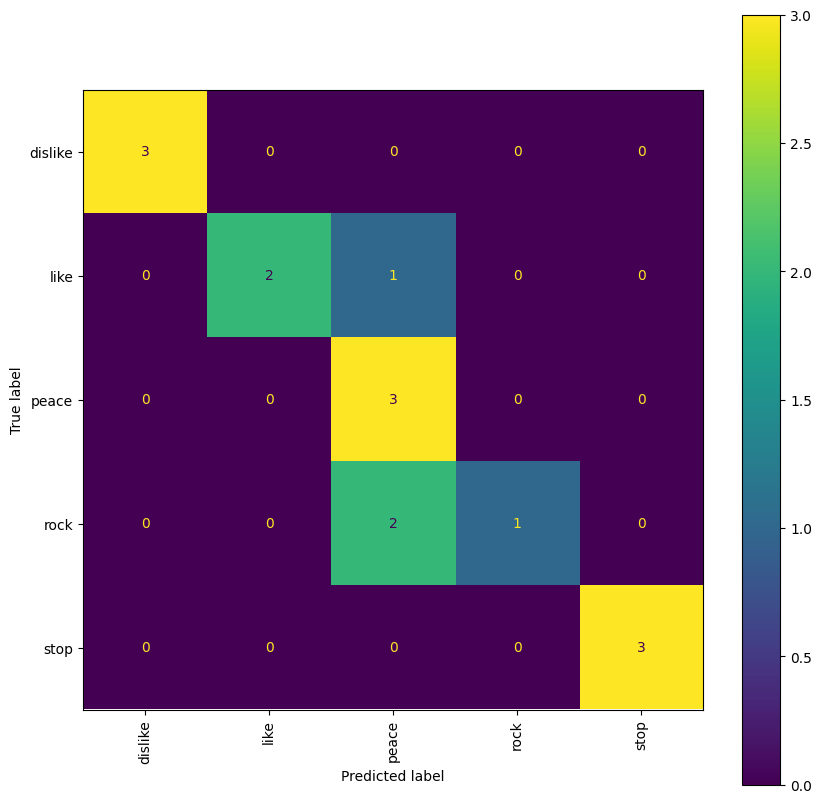

In [51]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.savefig('conf-matrix.png')